<a href="https://colab.research.google.com/github/EricCallaway/COSC_5313_homework_7/blob/main/AI_homework_7_RNN_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytreebank

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytreebank: filename=pytreebank-0.2.7-py3-none-any.whl size=37071 sha256=91df98df4ef129f8db41592c9706ca7fe49c2deebcf854ae05d9d7d1fd36707b
  Stored in directory: /root/.cache/pip/wheels/5b/84/1b/8fbd390149c4c56517bf3cb62bb25d3cf6f5cf575e66710ced
Successfully built pytreebank


In [2]:
import pytreebank
# load the sentiment treebank corpus in the parenthesis format,
# e.g. "(4 (2 very ) (3 good))"
dataset = pytreebank.load_sst()
# add Javascript and CSS to the Ipython notebook
pytreebank.LabeledTree.inject_visualization_javascript()
# select and example to visualize
example = dataset["dev"][0]
# display it in the page
example.display()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Import necessary Libraries

In [25]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 5.1 MB/s 
     |████████████████████████████████| 287 kB 40.7 MB/s 


In [133]:
import numpy as np
import pandas as pd
import re
import string
import contractions
import wordcloud
import seaborn as sns

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score

from imblearn.over_sampling import SMOTE

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
from nltk.tree import Tree
import os

Import Dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Transform Dataset into Tabular Form

Here the full-sentence text and their class labels (for the train, dev, and test sets) are written to individual text files using a tab-delimiter between the sentence and class labels. 



In [37]:
# Load data
import pytreebank
import sys
import os

out_path = os.path.join(sys.path[0], 'sst_{}.txt')
dataset = pytreebank.load_sst('./trees')

# Store train, dev and test in separate files
for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1,
                item.to_labeled_lines()[0][1]
            ))
# Print the length of the training set
print(len(dataset['train']))

8544


Exploratory Data Analysis

In [38]:
# Read train data
df = pd.read_csv('/content/sst_train.txt', sep='\t', header=None, names=['truth', 'text'])
df['truth'] = df['truth'].str.replace('__label__', '')
df['truth'] = df['truth'].astype(int).astype('category')
df.head()

,truth,text
0,4,The Rock is destined to be the 21st Century 's...
1,5,The gorgeously elaborate continuation of `` Th...
2,4,Singer/composer Bryan Adams contributes a slew...
3,3,You 'd think by now America would have had eno...
4,4,Yet the act is still charming here .


Calculating the length of each record in our text column

In [39]:
# calculating length of each record in our df
df['length'] = df['text'].apply(lambda x: len(x))
df.head()

,truth,text,length
0,4,The Rock is destined to be the 21st Century 's...,181
1,5,The gorgeously elaborate continuation of `` Th...,226
2,4,Singer/composer Bryan Adams contributes a slew...,208
3,3,You 'd think by now America would have had eno...,100
4,4,Yet the act is still charming here .,36


Notice now we have 8,544 training samples

In [40]:
df.shape[0]

8544

Word Cloud

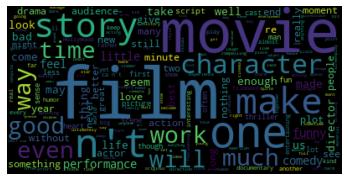

In [43]:
common_words=''
for i in df.text:
  i = str(i)
  tokens = i.split()
  common_words += ' '.join(tokens)+' '
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Clean the text

In [44]:
# some text cleaning functions
def convert_to_lower(text):
    return text.lower()

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def contraction_mapping(text):
  expanded_words = []
  for word in text.split():
    #using contractions.fix to expand the shortened words
    expanded_words.append(contractions.fix(word))
  expanded_text = ' '.join(expanded_words)
  return expanded_text

In [45]:
df['text'] = df['text'].apply(lambda x: convert_to_lower(x))
df['text'] = df['text'].apply(lambda x: remove_numbers(x))
df['text'] = df['text'].apply(lambda x: remove_punctuation(x))
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))
df['text'] = df['text'].apply(lambda x: remove_extra_white_spaces(x))
df['text'] = df['text'].apply(lambda x: lemmatizing(x))
df['text'] = df['text'].apply(lambda x: contraction_mapping(x))

Notice how imbalanced the training data is. Most of the training samples belong to classes 2 (Negative) and 4 (Positive).

Text(0, 0.5, 'Label')

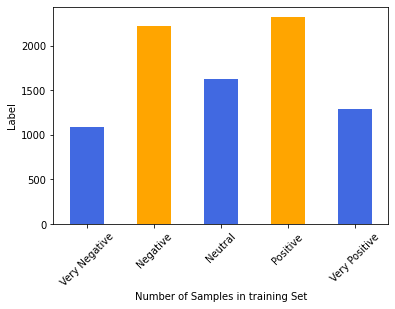

In [135]:
ax = df['truth'].value_counts(sort=False).plot(kind='bar', color=['royalblue', 'orange'])
ax.set_xlabel('Number of Samples in training Set')
ax.set_xticklabels(['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_ylabel('Label')

Length of data after cleaning

In [47]:
df['length_after_cleaning'] = df['text'].apply(lambda x: len(x))
df.head()

,truth,text,length,length_after_cleaning
0,4,rock destined st century new conan going make ...,181,120
1,5,gorgeously elaborate continuation lord ring tr...,226,159
2,4,singercomposer bryan adam contributes slew son...,208,141
3,3,think america would enough plucky british ecce...,100,62
4,4,yet act still charming,36,22


Tokenize Text

In [48]:
results = set()
df['text'].str.lower().str.split().apply(results.update)
print(len(results))

14778


In [50]:
tokenizer = Tokenizer(num_words=15000, split=' ')
tokenizer.fit_on_texts(df.text.values)
x = tokenizer.texts_to_sequences(df.text)
x = pad_sequences(x)

Balance the Dataset

In [54]:
x_data = pd.DataFrame(x)
sm = SMOTE(random_state=1337)
x_res, y_res = sm.fit_resample(x_data, df.truth)

In [55]:
y_res.value_counts()

1    2322
2    2322
3    2322
4    2322
5    2322
Name: truth, dtype: int64

In [56]:
y_res_plot = y_res.to_frame()

Notice how now the data is balanced 

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

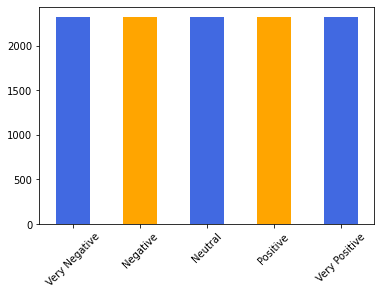

In [63]:
y_res_plot['truth'].value_counts().plot(kind='bar', color=['royalblue', 'orange'])
plt.xticks([0, 1, 2, 3, 4], ['Very Negative', 'Negative', 'Neutral','Positive', 'Very Positive'])
plt.xticks(rotation=45)

Splitting the Dataset into Train,  Test, and Validation sets.

The Dataset will be split into the following:


*   Training: 70%
*   Testing: 15%
*   Validation: 15%






In [71]:
x_train, x_rem, y_train, y_rem = train_test_split(x_res,y_res, train_size=0.7, random_state=1337, stratify=y_res)

x_val, x_test, y_val, y_test = train_test_split(x_rem,y_rem, test_size=0.5, random_state=1337, stratify=y_rem)

Build Model

In [122]:
vocab_size = 15000
embedding_dim = 64
max_length = 200


model = Sequential([
        Embedding(vocab_size, embedding_dim),
        Bidirectional(LSTM(embedding_dim)),
        Dense(embedding_dim, activation='relu'),
        Dense(6, activation='softmax')
])

Compile Model

In [123]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Sumarizaiton of the Model

In [124]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 64)          960000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 6)                 390       
                                                                 
Total params: 1,034,694
Trainable params: 1,034,694
Non-trainable params: 0
_________________________________________________________________


Train the Model

In [125]:
epochs=5
batch_size=32

# fit the model
history = model.fit(
  x_train,
  y_train,
  validation_data=(x_val,y_val),
  epochs=epochs,
  batch_size=batch_size,
  shuffle=True,
  verbose='auto'
  )

Epoch 1/5
254/254 [==============================] - 17s 47ms/step - loss: 1.6247 - accuracy: 0.2123 - val_loss: 1.6122 - val_accuracy: 0.2319
Epoch 2/5
254/254 [==============================] - 11s 43ms/step - loss: 1.4108 - accuracy: 0.3847 - val_loss: 1.5549 - val_accuracy: 0.3031
Epoch 3/5
254/254 [==============================] - 11s 43ms/step - loss: 0.9527 - accuracy: 0.6234 - val_loss: 1.8202 - val_accuracy: 0.2951
Epoch 4/5
254/254 [==============================] - 11s 44ms/step - loss: 0.4739 - accuracy: 0.8315 - val_loss: 2.3545 - val_accuracy: 0.2933
Epoch 5/5
254/254 [==============================] - 11s 44ms/step - loss: 0.2428 - accuracy: 0.9191 - val_loss: 3.0923 - val_accuracy: 0.2905


In [120]:
print(set(df.truth))

{1, 2, 3, 4, 5}


In [121]:
print(set(y_train))

{1, 2, 3, 4, 5}


Visualizing Accuracy and Loss

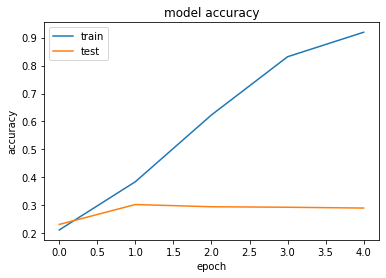

In [126]:
#Summarizing History for Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

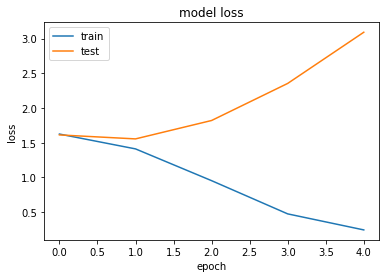

In [127]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion Matrix for Training

In [128]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual')
    plt.xlabel('Prediction')

In [136]:
predicted_classes = model.predict(x_train)
y_true = y_train
val_pred_classes = model.predict(x_val)

In [131]:
pred_df = pd.DataFrame(predicted_classes, columns = [0,1,2,3,4,5])
class_predictions = pred_df.idxmax(axis=1)

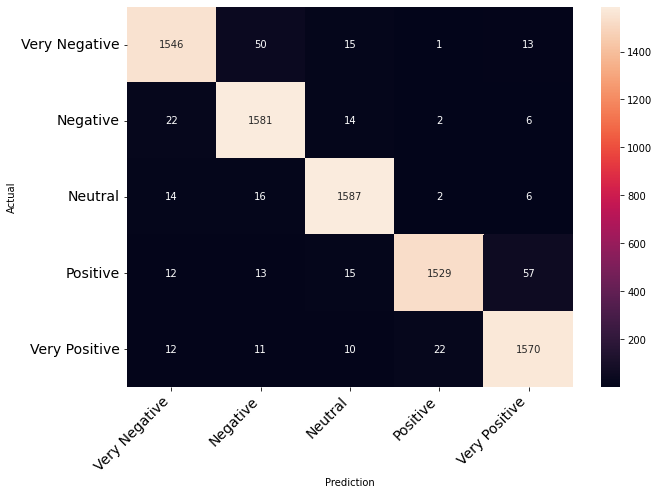

In [134]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, class_predictions)
print_confusion_matrix(cm, ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"])

In [139]:
val_predicted_df = pd.DataFrame(val_pred_classes, columns = [0,1,2,3,4,5])
val_predictions = val_predicted_df.idxmax(axis=1)

Validation Confusion Matrix

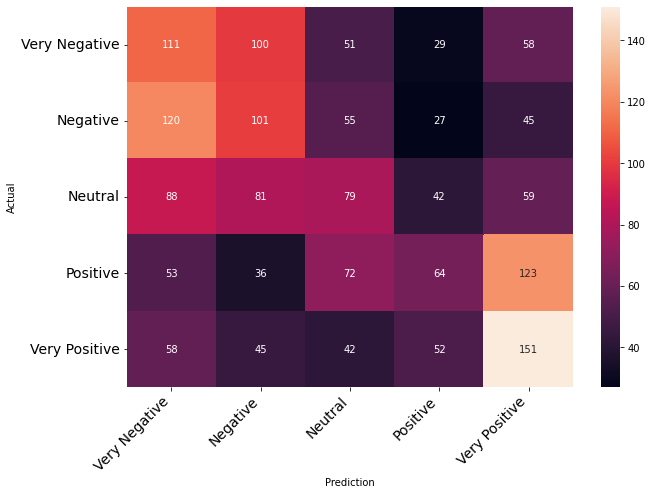

In [140]:
cm = confusion_matrix(y_val, val_predictions)
print_confusion_matrix(cm, ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"])